In [15]:
import numpy as np 
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import geopandas as gpd
from shapely.geometry import Point

In [16]:
#Read data
train_vals = pd.read_csv('../data/edited_train_set.csv')
test_vals = pd.read_csv('../data/edited_test_set.csv')

#Index
train_vals.set_index('id', inplace=True)
test_vals.set_index('id', inplace=True)

### sklearn setup

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

There are many categorical columns in our data, which are currently filled in as strings. We will need to encode those to integers for the model to understand them. 

In [18]:
#Instantiate
le = LabelEncoder()

In [19]:
#Grab our target labels and encode
y = le.fit_transform(train_vals.status_group)

In [20]:
#Remember: 0=func, 1=repair, 2=broken
classes = le.classes_

In [21]:
#Grab our features
x = train_vals.iloc[:, :-1]

In [22]:
#Encode features
for col in x.columns[2:]:
    #Pop and constr year aren't categorical:
    if (col not in ['gps_height', 'population', 'construction_year']): 
        #Apply on test_vals for later as well as on our training x
        x[col] = le.fit_transform(x[col])
        test_vals[col] = le.fit_transform(test_vals[col])

In [23]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=10)

#### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [25]:
#Parameter grid for hyperparameter tuning
param_grid = {'n_estimators': [250, 500, 750],
              'max_depth': [25, 35, 45], 
             'max_features': ['auto', 'log2', None]}

In [26]:
#Build our model - note: this cell takes a while
ranfor = GridSearchCV(RandomForestClassifier(n_jobs=-1), param_grid, cv=5,
                             return_train_score=True).fit(X_train, y_train)

In [27]:
#Best paramaters
print(ranfor.best_params_)

{'max_depth': 25, 'max_features': 'log2', 'n_estimators': 500}


In [28]:
#How important is each feature in our model?
for i, col in enumerate(X_train.columns):
    print(col, ": %.4f" % ranfor.best_estimator_.feature_importances_[i])

longitude : 0.1073
latitude : 0.1017
gps_height : 0.0917
region : 0.0413
basin : 0.0205
lga : 0.0401
public_meeting : 0.0069
scheme_management : 0.0162
permit : 0.0118
construction_year : 0.1576
population : 0.1100
extraction_type : 0.0359
management : 0.0168
payment_type : 0.0327
water_quality : 0.0120
quantity : 0.1169
source : 0.0222
waterpoint_type : 0.0584


Construction year, Longitude and Latitude are comfortably the most important parameters in our model, followed in the distance by quantity and region. 

In [29]:
print("Score on train set: %.4f" % ranfor.score(X_train, y_train))
print("Score on test set: %.4f" % ranfor.score(X_test, y_test))

Score on train set: 0.9991
Score on test set: 0.8796


In [30]:
#Get our label predictions based on the test set we've split off earlier
y_pred = ranfor.predict(X_test)

### Evaluation

In [31]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import (classification_report, precision_recall_curve, auc, roc_curve)

C:\Users\youri\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


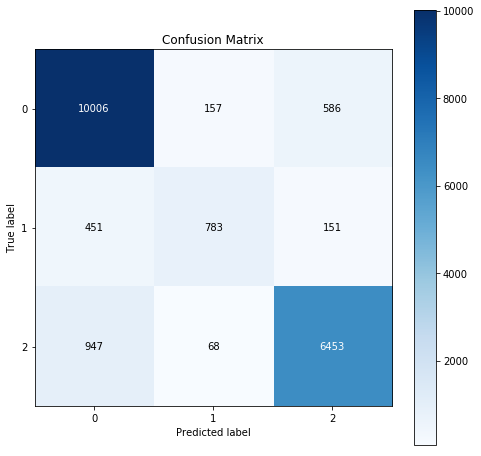

In [32]:
#Confusion Matrix - how many did we get right and wrong?
fig, ax = plt.subplots(figsize=(8,8))
skplt.metrics.plot_confusion_matrix(y_test, y_pred, ax=ax)

In [33]:
#How many did we get wrong, in total?
print("Total number of predictions: {}".format(len(y_pred)))
print("Number of wrong status predictions: {}".format(len(y_pred[y_pred != y_test])))
#How much does our model outperform randomness?
print("Cohen kappa score: {:.4f}".format(cohen_kappa_score(y_test, y_pred)))

Total number of predictions: 19602
Number of wrong status predictions: 2360
Cohen kappa score: 0.7760


In [34]:
#Classification report: model performance per category
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.88      0.93      0.90     10749
          1       0.78      0.57      0.65      1385
          2       0.90      0.86      0.88      7468

avg / total       0.88      0.88      0.88     19602



#### Grab predictions on test set

In [35]:
new_pred = ranfor.predict(test_vals)

### Submission

In [36]:
submittable = pd.DataFrame(new_pred, index=test_vals.index)

In [37]:
submittable.columns = ['status_group']

In [38]:
submittable.status_group.replace({0: classes[0], 
                                 1: classes[1],
                                 2: classes[2]}, inplace=True)

In [39]:
submittable.to_csv('../data/my_submission.csv')